<a href="https://colab.research.google.com/github/yangmz0528/Cracks_Dectection/blob/main/Crack_Detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concrete Crack Image Detection



## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import os, json
from glob import glob
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import Model, layers, callbacks
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input, Conv2D, MaxPool2D, Flatten


## 2. Download Dataset and making into a DataFrame

In [3]:
!ls

archive  sample_data  saved_model


In [4]:
!wget -qq https://www.dropbox.com/s/bpy28t6mgbu96wq/crack_classification.zip
!unzip -qq crack_classification.zip
!rm crack_classification.zip

!ls

replace archive/Negative/00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: archive  sample_data  saved_model


In [5]:
!ls archive

Negative  Positive


In [6]:
# use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.
negative_dir = glob.glob('./archive/Negative/*.jpg')
positive_dir = glob.glob('./archive/Positive/*.jpg')


names = ['negative', 'positive']

# Check
len(negative_dir)

20000

In [7]:
# Make a dataframe based on the filenames
df_neg = pd.DataFrame(negative_dir, columns = ["filename"])
df_pos = pd.DataFrame(positive_dir, columns = ["filename"])


# Add Class columns 
df_neg['class'] = pd.Series([0 for x in range(len(df_neg.index))], index=df_neg.index)
df_pos['class'] = pd.Series([1 for x in range(len(df_pos.index))], index=df_pos.index)

# Concat both dataframes (negative & positive) & Shuffle
df_final = pd.concat([df_neg, df_pos], axis=0).sample(frac=1.0).reset_index(drop=np.true_divide)
df_final['class'] = df_final['class'].astype(str)


In [8]:
df_final.head()

,filename,class
0,./archive/Negative/04869.jpg,0
1,./archive/Positive/17681_1.jpg,1
2,./archive/Negative/16322.jpg,0
3,./archive/Negative/16713.jpg,0
4,./archive/Negative/03325.jpg,0


0    20000
1    20000
Name: class, dtype: int64


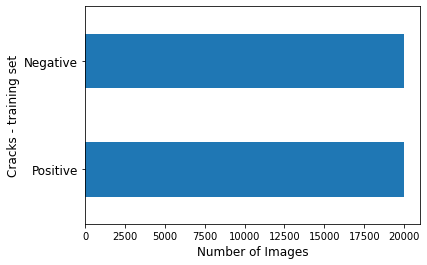

In [9]:
# Examine the data
print(df_final['class'].value_counts())


ax = df_final['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Images", fontsize=12)
ax.set_ylabel("Cracks - training set", fontsize=12)
ax.set_yticklabels(['Positive','Negative'], rotation=0, fontsize=12)
plt.show()

In [10]:
 # Train-test split the data
 train_df, test_df = train_test_split(
     df_final.sample(40000, random_state=42),
     train_size=0.8,
     shuffle=True,
     random_state=42
 )

## 3. Loading Image Data

In [11]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255 # do not include validation split
)

In [12]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False, # do not shuffle the test
    seed=42
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


## 4. Training the Model - CNN

In [13]:
train_data.next()[1]

array([1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [14]:
inputs = Input(shape=(128, 128, 3))
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x) # or do flattening
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
        )
    ]
)

Epoch 1/100
800/800 [==============================] - 54s 63ms/step - loss: 0.4345 - accuracy: 0.8205 - val_loss: 0.2039 - val_accuracy: 0.9336
Epoch 2/100
800/800 [==============================] - 45s 56ms/step - loss: 0.1338 - accuracy: 0.9638 - val_loss: 0.1590 - val_accuracy: 0.9345
Epoch 3/100
800/800 [==============================] - 44s 55ms/step - loss: 0.0921 - accuracy: 0.9725 - val_loss: 0.0883 - val_accuracy: 0.9762
Epoch 4/100
800/800 [==============================] - 44s 54ms/step - loss: 0.0801 - accuracy: 0.9753 - val_loss: 0.0773 - val_accuracy: 0.9736
Epoch 5/100
800/800 [==============================] - 43s 54ms/step - loss: 0.0748 - accuracy: 0.9763 - val_loss: 0.0979 - val_accuracy: 0.9803
Epoch 6/100
800/800 [==============================] - 44s 55ms/step - loss: 0.0725 - accuracy: 0.9775 - val_loss: 0.0715 - val_accuracy: 0.9744
Epoch 7/100
800/800 [==============================] - 45s 56ms/step - loss: 0.0688 - accuracy: 0.9785 - val_loss: 0.0780 - val_ac

In [17]:
model.save('./saved_model/cnn_model')

In [18]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': 'Epoch', 'value': 'Loss'},
    title='Training and Validation Loss Over Time'
)

fig.show()

In [19]:
fig = px.line(
history.history,
y = ['accuracy','val_accuracy'],
labels = {'index':'epoch','value':'accuracy '},
title = ' Training and Validation Accuracy Over Time ')
fig.show()

In [20]:
np.squeeze((model.predict(test_data) >= 0.5).astype(int))

250/250 [==============================] - 11s 42ms/step


array([0, 0, 1, ..., 1, 0, 1])

In [21]:
test_data.labels

[0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,


In [22]:
# Evaluation of Model

def evaluate_model(model, test_data, prefix=''):
  results = model.evaluate(test_data, verbose=0)
  loss = results[0]
  acc = results[1]
  print("Test Loss: {:.5f}".format(loss))
  print("Test Accuracy: {:.2f}".format(acc*100))

  y_pred = np.squeeze(model.predict(test_data)>=0.5).astype(int)
  cm = confusion_matrix(test_data.labels, y_pred)
  clr = classification_report(test_data.labels, y_pred, target_names=['Negative', 'Positive'])

  plt.figure(figsize=(6,6))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=np.arange(2) + 0.5, labels=['Negative', 'Positive']) # get ticks in the middle of the boxes
  plt.yticks(ticks=np.arange(2) + 0.5, labels=['Negative', 'Positive'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix - "+prefix)
  plt.show()

  print("Classification Report: \n ----------------------\n", clr)

Test Loss: 0.06028
Test Accuracy: 98.34
250/250 [==============================] - 10s 42ms/step


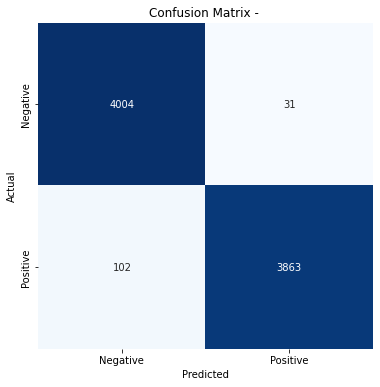

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       0.98      0.99      0.98      4035
    Positive       0.99      0.97      0.98      3965

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000



In [23]:
evaluate_model(model, test_data, prefix='CNN')

## 5 - Tranfer Learning - MobileNet

In [24]:
train_gen_mobile = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split = 0.2
)

test_gen_mobile = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [25]:
train_data_mobile = train_gen_mobile.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224), # mobilenet default
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data_mobile = train_gen_mobile.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data_mobile = train_gen_mobile.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [26]:
# Download feature extractor

feature_extractor = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False, # build our own classification
    pooling='avg'
)

feature_extractor.trainable = False

In [27]:
feature_extractor.output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_1')>

In [28]:
inputs = feature_extractor.input
x = Dense(128, activation='relu')(feature_extractor.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_mobile = Model(inputs=inputs, outputs=outputs)

print(model_mobile.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [29]:
model_mobile.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [30]:
# Train the model

history_mobile = model_mobile.fit(
    train_data_mobile,
    validation_data = val_data_mobile,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
        )
    ]
)

Epoch 1/100
800/800 [==============================] - 74s 89ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.0051 - val_accuracy: 0.9984
Epoch 2/100
800/800 [==============================] - 70s 88ms/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0041 - val_accuracy: 0.9984
Epoch 3/100
800/800 [==============================] - 70s 87ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0209 - val_accuracy: 0.9955
Epoch 4/100
800/800 [==============================] - 68s 86ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0053 - val_accuracy: 0.9980
Epoch 5/100
800/800 [==============================] - 77s 96ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0070 - val_accuracy: 0.9978


In [32]:
model_mobile.save('./saved_model/mobilenet_model')

In [33]:
fig = px.line(
    history_mobile.history,
    y=['loss', 'val_loss'],
    labels={'index': 'Epoch', 'value': 'Loss'},
    title='Training and Validation Loss Over Time'
)

fig.show()

In [34]:
fig = px.line(
history_mobile.history,
y = ['accuracy','val_accuracy'],
labels = {'index':'epoch','value':'accuracy '},
title = ' Training and Validation Accuracy Over Time ')
fig.show()

Test Loss: 0.00862
Test Accuracy: 99.64
250/250 [==============================] - 18s 69ms/step


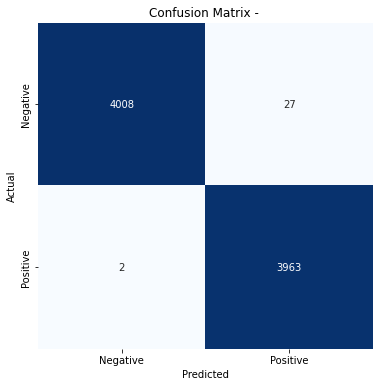

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       1.00      0.99      1.00      4035
    Positive       0.99      1.00      1.00      3965

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [35]:
evaluate_model(model_mobile, test_data_mobile, prefix='MobileNet')

## 6 - Tranfer Learning - InceptionV3

In [36]:
train_gen_incep = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input,
    validation_split = 0.2
)

test_gen_incep = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
)

In [38]:
train_data_incep = train_gen_incep.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299), # inceptionv3 default
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data_incep = train_gen_incep.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data_incep = train_gen_incep.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [40]:
# Download feature extractor

feature_extractor_incep = tf.keras.applications.InceptionV3(
    input_shape=(299, 299, 3),
    weights='imagenet',
    include_top=False, # build our own classification
    pooling='avg'
)

feature_extractor_incep.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [42]:
feature_extractor_incep.output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d_2')>

In [44]:
# We will use the part of the pre_trained model from input later until the layer 'mixed7'
# You can also choose different layer for starting
last_layer = feature_extractor_incep.get_layer('mixed7') 
last_output = last_layer.output


#Then we add our layers 

#takes a average pooling in a way that flattenning an amount
x = GlobalAveragePooling2D()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dropout layer to prevent overfitting
#x = layers.Dropout(0.2)(x)  

# Add a final sigmoid layer for classification
outputs = Dense(1, activation='sigmoid')(x)   


model_incep = Model(inputs=feature_extractor_incep.inputs, outputs=outputs)

print(model_incep.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d_2[0][0]']               
 alization)                     )                                                           

In [45]:
model_incep.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [46]:
# Train the model

history_incep = model_incep.fit(
    train_data_incep,
    validation_data = val_data_incep,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
        )
    ]
)

Epoch 1/100
800/800 [==============================] - 123s 147ms/step - loss: 0.0191 - accuracy: 0.9957 - val_loss: 0.0032 - val_accuracy: 0.9986
Epoch 2/100
800/800 [==============================] - 107s 133ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0076 - val_accuracy: 0.9978
Epoch 3/100
800/800 [==============================] - 106s 133ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0033 - val_accuracy: 0.9989
Epoch 4/100
800/800 [==============================] - 106s 132ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0013 - val_accuracy: 0.9994
Epoch 5/100
800/800 [==============================] - 107s 133ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0015 - val_accuracy: 0.9998
Epoch 6/100
800/800 [==============================] - 106s 133ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0014 - val_accuracy: 0.9994
Epoch 7/100
800/800 [==============================] - 106s 133ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0

In [47]:
model_incep.save('./saved_model/inceptionv3_model')

In [48]:
fig = px.line(
    history_incep.history,
    y=['loss', 'val_loss'],
    labels={'index': 'Epoch', 'value': 'Loss'},
    title='Training and Validation Loss Over Time'
)

fig.show()

In [49]:
fig = px.line(
history_incep.history,
y = ['accuracy','val_accuracy'],
labels = {'index':'epoch','value':'accuracy '},
title = ' Training and Validation Accuracy Over Time ')
fig.show()

Test Loss: 0.00394
Test Accuracy: 99.90
250/250 [==============================] - 27s 105ms/step


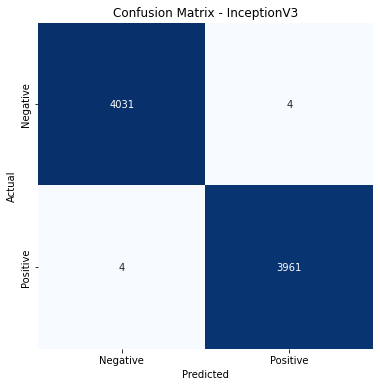

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4035
    Positive       1.00      1.00      1.00      3965

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [52]:
evaluate_model(model_incep, test_data_incep, prefix='InceptionV3')

In [ ]:
# kill the VM and restart Colab with a new machine
!kill -9 -1